## Загрузка библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from PIL import Image
import cv2
import os

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# from albumentations import Compose
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm
from typing import List, Tuple, Dict, Optional
# from torch.autograd import Variable
# from torchvision import datasets
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import torch.utils.data as data_utils

# import skimage.io
# from skimage.transform import resize

# from torchvision import transforms
# import imageio
# import kagglehub

# %matplotlib inline

## Загрузка датасета

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks/DeepL_Geoproject

/content/drive/MyDrive/ColabNotebooks/DeepL_Geoproject


In [ ]:
!unzip geodata_train_small.zip

Archive:  geodata_train_small.zip
replace train_small/gt/austin1.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
!ls

"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


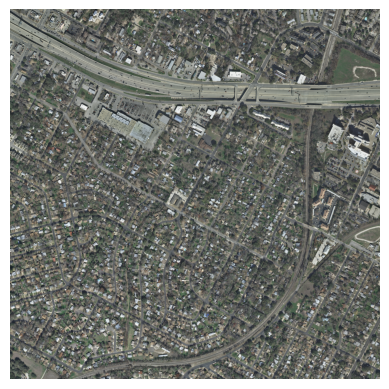

In [ ]:
# Загружаем изображение
img_path = '/content/drive/MyDrive/ColabNotebooks/DeepL_Geoproject/train_small/images/austin1.tif'  # Укажите свой путь
img = Image.open(img_path)

# Отображаем
plt.imshow(img)
plt.axis('off')  # Убрать оси
plt.show()

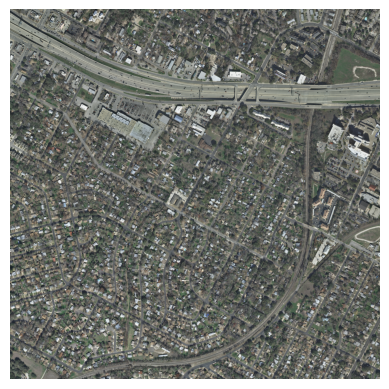

In [8]:
# Загружаем изображение
img_path = 'train_small/images/austin1.tif'  # Укажите свой путь
img = Image.open(img_path)

# Отображаем
plt.imshow(img)
plt.axis('off')  # Убрать оси
plt.show()

### Вариант с сохранением патчей на диск

In [ ]:
def split_image_into_patches(image_path, output_dir, patch_size=512, overlap=64):
    """
    Разбивает изображение на патчи с заданным перекрытием.
    
    Параметры:
        image_path (str): Путь к исходному изображению
        output_dir (str): Директория для сохранения патчей
        patch_size (int): Размер патча (квадратный)
        overlap (int): Перекрытие между патчами в пикселях
    """

    # Получаем название файла
    filename_with_ext = os.path.basename(image_path)
    filename = os.path.splitext(filename_with_ext)[0]

    # Загрузка изображения
    image = Image.open(image_path)
    img_array = np.array(image)
    
    # Проверка размеров изображения
    height, width = img_array.shape[:2]
    # print(f"Исходное изображение: {width}x{height} пикселей")
    
    # Создание директории для сохранения (если не существует)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Вычисление шага (stride)
    stride = patch_size - overlap
    
    # Подсчет количества патчей по ширине и высоте
    num_patches_x = (width - overlap) // stride
    num_patches_y = (height - overlap) // stride
    
    # Корректировка, если изображение не делится ровно
    if (width - overlap) % stride != 0:
        num_patches_x += 1
    if (height - overlap) % stride != 0:
        num_patches_y += 1
    
    # print(f"Будет создано {num_patches_x}x{num_patches_y} = {num_patches_x*num_patches_y} патчей")
    
    # Генерация и сохранение патчей
    patch_num = 0
    for y in range(0, height - overlap, stride):
        for x in range(0, width - overlap, stride):
            # Определение координат
            x_start = x
            y_start = y
            x_end = min(x_start + patch_size, width)
            y_end = min(y_start + patch_size, height)
            
            # Извлечение патча
            patch = img_array[y_start:y_end, x_start:x_end]
            
            # Если патч меньше нужного размера, дополняем нулями
            if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                pad_height = patch_size - patch.shape[0]
                pad_width = patch_size - patch.shape[1]
                
                if len(img_array.shape) == 3:  # Цветное изображение
                    patch = np.pad(patch, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')
                else:  # Градации серого
                    patch = np.pad(patch, ((0, pad_height), (0, pad_width)), mode='constant')
            
            # Сохранение патча
            patch_img = Image.fromarray(patch)
            output_path = os.path.join(output_dir, f"{filename}_patch_{patch_num:04d}.tif")
            patch_img.save(output_path)
            patch_num += 1
    
    # print(f"Сохранено {patch_num} патчей в директорию {output_dir}")


In [22]:
split_image_into_patches(img_path, patches_path, patch_size=512, overlap=8)

Исходное изображение: 5000x5000 пикселей
Будет создано 10x10 = 100 патчей
Сохранено 100 патчей в директорию train_small/patches


In [23]:
dataset_path = 'train_small/'

images_path = os.path.join(dataset_path, 'images')
gt_path = os.path.join(dataset_path, 'gt')
images_patches_path = os.path.join(dataset_path, 'images_patches')
gt_patches_path = os.path.join(dataset_path, 'gt_patches')

In [54]:
def creat_patches_to_disc():
    for img_name in os.listdir(images_path):
        if img_name.endswith('.tif'):
            mask_name = img_name  # Предполагаем одинаковые имена
            img_path = os.path.join(images_path, img_name)
            mask_path = os.path.join(gt_path, mask_name)
            split_image_into_patches(img_path, images_patches_path, patch_size=512, overlap=8)
            split_image_into_patches(mask_path, gt_patches_path, patch_size=512, overlap=8)
        

### Вариант с преобразованием в массив

In [70]:
import numpy as np
from PIL import Image

def image_to_patches(image_path, patch_size=512, overlap=64):
    """
    Разбивает изображение на патчи с заданным перекрытием и возвращает массив патчей.
    
    Параметры:
        image_path (str): Путь к исходному изображению
        patch_size (int): Размер патча (квадратный)
        overlap (int): Перекрытие между патчами в пикселях
    
    Возвращает:
        list: Список numpy массивов с патчами
        tuple: Размерность сетки патчей (y_patches, x_patches)
    """
    # Загрузка изображения
    image = Image.open(image_path)
    img_array = np.array(image)
    
    # Проверка размеров изображения
    height, width = img_array.shape[:2]
    # print(f"Исходное изображение: {width}x{height} пикселей")
    
    # Вычисление шага (stride)
    stride = patch_size - overlap
    
    # Подсчет количества патчей по ширине и высоте
    num_patches_x = (width - overlap) // stride
    num_patches_y = (height - overlap) // stride
    
    # Корректировка, если изображение не делится ровно
    if (width - overlap) % stride != 0:
        num_patches_x += 1
    if (height - overlap) % stride != 0:
        num_patches_y += 1
    
    # print(f"Создается {num_patches_y}x{num_patches_x} = {num_patches_y*num_patches_x} патчей")
    
    # Список для хранения патчей
    patches = []
    
    # Генерация патчей
    for y in range(0, height - overlap, stride):
        for x in range(0, width - overlap, stride):
            # Определение координат
            x_start = x
            y_start = y
            x_end = min(x_start + patch_size, width)
            y_end = min(y_start + patch_size, height)
            
            # Извлечение патча
            patch = img_array[y_start:y_end, x_start:x_end]
            
            # Если патч меньше нужного размера, дополняем нулями
            if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                pad_height = patch_size - patch.shape[0]
                pad_width = patch_size - patch.shape[1]
                
                if len(img_array.shape) == 3:  # Цветное изображение
                    patch = np.pad(patch, ((0, pad_height), (0, pad_width), (0, 0)), 
                                mode='constant', constant_values=0)
                else:  # Градации серого
                    patch = np.pad(patch, ((0, pad_height), (0, pad_width)), 
                                mode='constant', constant_values=0)
            
            # Добавление патча в список
            patches.append(patch)
    
    # Преобразование списка в numpy массив для удобства
    patches_array = np.array(patches)
    
    # Возвращаем массив патчей и размерность сетки
    return patches_array


In [49]:
input_image = 'train_small/images/austin1.tif'
input_gt = 'train_small/gt/austin1.tif'
    
# Получаем патчи
image_patches = image_to_patches(input_image, patch_size=512, overlap=8)
gt_patches = image_to_patches(input_gt, patch_size=512, overlap=8)

Исходное изображение: 5000x5000 пикселей
Создается 10x10 = 100 патчей
Исходное изображение: 5000x5000 пикселей
Создается 10x10 = 100 патчей


In [104]:
image_patches.shape

(100, 512, 512, 3)

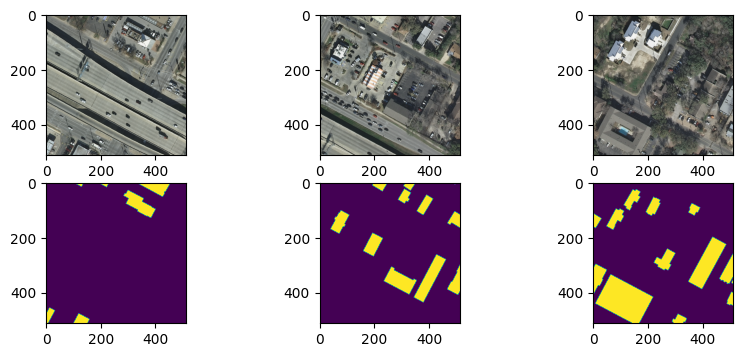

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(10,4))

for i in range(3):
    patch = image_patches[i]
    axes[0, i].imshow(patch)
    patch = gt_patches[i]
    axes[1, i].imshow(patch)

plt.show()


In [ ]:
dataset_path = 'train_small/'



In [109]:
def creat_patches_to_array(dataset_path='train_small/'):
    """
    Функция создает массивы патчей из исходных изображений
    На вход подается путь к датасету (внутри должны находиться папки images и gt)
    """
    images_folder_path = os.path.join(dataset_path, 'images')
    gt_folder_path = os.path.join(dataset_path, 'gt')

    all_image_patches_list = []
    all_gt_patches_list = []
    for img_name in os.listdir(images_folder_path):
        if img_name.endswith('.tif'):
            gt_name = img_name  # Предполагаем одинаковые имена
            img_path = os.path.join(images_folder_path, img_name)
            gt_path = os.path.join(gt_folder_path, gt_name)

            image_patches = image_to_patches(img_path, patch_size=512, overlap=8)
            gt_patches = image_to_patches(gt_path, patch_size=512, overlap=8)
            
            all_image_patches_list.append(image_patches)
            all_gt_patches_list.append(gt_patches)

    all_image_patches = np.vstack(all_image_patches_list)
    all_gt_patches = np.vstack(all_gt_patches_list)

    return all_image_patches, all_gt_patches

In [110]:
image_patches, gt_patches = creat_patches_to_array()

In [116]:
image_patches.shape

(600, 512, 512, 3)

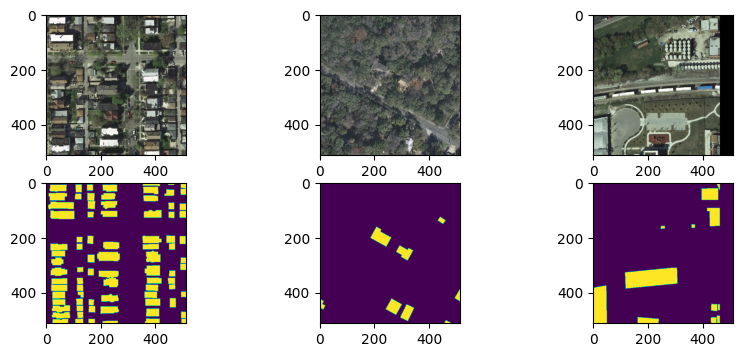

In [121]:
fig, axes = plt.subplots(2, 3, figsize=(10,4))

for i in range(3):
    j = np.random.randint(0, 601)
    patch = image_patches[j]
    axes[0, i].imshow(patch)
    patch = gt_patches[j]
    axes[1, i].imshow(patch)

plt.show()

### Пример готового класса для разбиение картинок на патчи

In [ ]:
class LargeImageDataset(Dataset):
    def __init__(self,
                 image_path: str,
                 patch_size: int = 512,
                 overlap: int = 64,
                 transform: Optional[callable] = None):
        """
        Args:
            image_path: Путь к большому изображению
            patch_size: Размер квадратного патча
            overlap: Перекрытие между патчами (в пикселях)
            transform: Аугментации (Albumentations)
        """
        # Загрузка изображения с OpenCV
        self.image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)  # HxWxC
        self.h, self.w = self.image.shape[:2]
        self.patch_size = patch_size
        self.overlap = overlap
        self.transform = transform

        # Рассчитываем координаты патчей
        self.coords = self._calculate_patch_coords()

    def _calculate_patch_coords(self) -> list:
        """Генерирует список координат (y,x) для каждого патча"""
        coords = []
        step = self.patch_size - self.overlap

        for y in range(0, self.h - self.overlap, step):
            for x in range(0, self.w - self.overlap, step):
                coords.append((y, x))

        return coords

    def __len__(self) -> int:
        return len(self.coords)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
        y, x = self.coords[idx]

        # Вырезаем патч с проверкой границ
        patch = self.image[
            y:min(y+self.patch_size, self.h),
            x:min(x+self.patch_size, self.w)
        ]

        # Дополняем нулями, если патч меньше нужного размера
        if patch.shape[0] < self.patch_size or patch.shape[1] < self.patch_size:
            pad_h = max(0, self.patch_size - patch.shape[0])
            pad_w = max(0, self.patch_size - patch.shape[1])
            patch = np.pad(patch, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')

        # Применяем аугментации
        if self.transform:
            patch = self.transform(image=patch)['image']

        # Конвертируем в torch.Tensor (CxHxW) и нормализуем
        patch = torch.from_numpy(patch).permute(2, 0, 1).float() / 255.0

        return patch, (y, x)

# Пример аугментаций с Albumentations
transform = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Создание DataLoader
dataset = LargeImageDataset(
    image_path="large_satellite.tif",
    patch_size=512,
    overlap=64,
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

### Функция реконструкции

In [ ]:
def reconstruct_image(predictions: list,
                    coords: list,
                    original_shape: Tuple[int, int],
                    patch_size: int = 512,
                    overlap: int = 64) -> np.ndarray:
    """
    Собирает предсказания в изображение исходного размера

    Args:
        predictions: Список предсказанных масок (numpy arrays)
        coords: Список координат (y,x) каждого патча
        original_shape: Размер исходного изображения (H,W)
        patch_size: Размер патча
        overlap: Перекрытие между патчами
    """
    reconstructed = np.zeros(original_shape)
    weights = np.zeros(original_shape)

    half_overlap = overlap // 2

    for pred, (y, x) in zip(predictions, coords):
        # Определяем границы патча с учетом перекрытия
        y_start = y + (half_overlap if y > 0 else 0)
        x_start = x + (half_overlap if x > 0 else 0)
        y_end = min(y + patch_size, original_shape[0])
        x_end = min(x + patch_size, original_shape[1])

        # Создаем весовую маску
        weight = np.ones_like(pred)

        # Плавное смешивание на границах
        if y > 0:
            weight[:half_overlap, :] = np.linspace(0, 1, half_overlap)[:, None]
        if y + patch_size < original_shape[0]:
            weight[-half_overlap:, :] = np.linspace(1, 0, half_overlap)[:, None]
        if x > 0:
            weight[:, :half_overlap] = weight[:, :half_overlap] * np.linspace(0, 1, half_overlap)
        if x + patch_size < original_shape[1]:
            weight[:, -half_overlap:] = weight[:, -half_overlap:] * np.linspace(1, 0, half_overlap)

        # Добавляем предсказание с весами
        reconstructed[y_start:y_end, x_start:x_end] += pred * weight
        weights[y_start:y_end, x_start:x_end] += weight

    # Убираем деление на 0
    weights[weights == 0] = 1
    return reconstructed / weights

### Пример готового класса для разбиения пар картинка+маска на патчи

In [ ]:
class DualPatchDataset(Dataset):
    def __init__(
        self,
        images_dir: str,
        masks_dir: str,
        patch_size: int = 512,
        overlap: int = 64,
        transform: Optional[Compose] = None,
        img_ext: str = '.tif'
    ):
        """
        Args:
            images_dir: Путь к папке с изображениями
            masks_dir: Путь к папке с масками
            patch_size: Размер квадратного патча
            overlap: Перекрытие между патчами (пиксели)
            transform: Аугментации Albumentations (должны поддерживать маски)
            img_ext: Расширение файлов (по умолчанию .tif)
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.patch_size = patch_size
        self.overlap = overlap
        self.transform = transform

        # Получаем список пар изображений
        self.files = self._get_file_pairs(img_ext)
        self.coords_cache = {}  # Кэш координат для каждого изображения

    def _get_file_pairs(self, ext: str) -> List[Dict[str, str]]:
        """Возвращает список пар {image_path, mask_path}"""
        pairs = []
        for img_name in os.listdir(self.images_dir):
            if img_name.endswith(ext):
                mask_name = img_name  # Предполагаем одинаковые имена
                img_path = os.path.join(self.images_dir, img_name)
                mask_path = os.path.join(self.masks_dir, mask_name)
                if os.path.exists(mask_path):
                    pairs.append({'image': img_path, 'mask': mask_path})
        return pairs

    def _load_image_pair(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        """Загружает пару изображение+маска"""
        img = cv2.cvtColor(cv2.imread(self.files[idx]['image']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.files[idx]['mask'], cv2.IMREAD_GRAYSCALE)
        return img, mask

    def _generate_patch_coords(self, h: int, w: int) -> List[Tuple[int, int]]:
        """Генерирует координаты патчей для изображения"""
        coords = []
        step = self.patch_size - self.overlap
        for y in range(0, h - self.overlap, step):
            for x in range(0, w - self.overlap, step):
                coords.append((y, x))
        return coords

    def __len__(self) -> int:
        """Общее количество патчей во всех изображениях"""
        total = 0
        for idx in range(len(self.files)):
            img, _ = self._load_image_pair(idx)
            h, w = img.shape[:2]
            if (h, w) not in self.coords_cache:
                self.coords_cache[(h, w)] = self._generate_patch_coords(h, w)
            total += len(self.coords_cache[(h, w)])
        return total

    def _get_global_index(self, idx: int) -> Tuple[int, int]:
        """Преобразует глобальный индекс в (индекс изображения, индекс патча)"""
        for img_idx in range(len(self.files)):
            img, _ = self._load_image_pair(img_idx)
            h, w = img.shape[:2]
            if (h, w) not in self.coords_cache:
                self.coords_cache[(h, w)] = self._generate_patch_coords(h, w)

            if idx < len(self.coords_cache[(h, w)]):
                return img_idx, idx
            idx -= len(self.coords_cache[(h, w)])
        raise IndexError("Index out of range")

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """Возвращает патчи изображения и маски с метаданными"""
        img_idx, patch_idx = self._get_global_index(idx)
        img, mask = self._load_image_pair(img_idx)
        h, w = img.shape[:2]
        y, x = self.coords_cache[(h, w)][patch_idx]

        # Вырезаем патчи
        img_patch = img[y:y+self.patch_size, x:x+self.patch_size]
        mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]

        # Дополнение нулями при необходимости
        if img_patch.shape[0] < self.patch_size or img_patch.shape[1] < self.patch_size:
            pad_h = max(0, self.patch_size - img_patch.shape[0])
            pad_w = max(0, self.patch_size - img_patch.shape[1])
            img_patch = np.pad(img_patch, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
            mask_patch = np.pad(mask_patch, ((0, pad_h), (0, pad_w)), mode='constant')

        # Аугментации
        if self.transform:
            transformed = self.transform(image=img_patch, mask=mask_patch)
            img_patch = transformed['image']
            mask_patch = transformed['mask']
        else:
        # Конвертация в тензоры
            img_tensor = torch.from_numpy(img_patch).permute(2, 0, 1).float() / 255.0
            mask_tensor = torch.from_numpy(mask_patch).unsqueeze(0).float()

        return {
            'image': img_tensor,
            'mask': mask_tensor,
            'origin': (img_idx, y, x)  # Для сборки предсказаний
        }

In [ ]:
transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.GaussianBlur(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Инициализация датасета
dataset = DualPatchDataset(
    images_dir='/content/drive/MyDrive/ColabNotebooks/DeepL_Geoproject/train_small/images',
    masks_dir='/content/drive/MyDrive/ColabNotebooks/DeepL_Geoproject/train_small/gt',
    patch_size=512,
    overlap=64,
    transform=transform
)


In [ ]:
# Создание DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

In [ ]:
dataset[0]

TypeError: expected np.ndarray (got Tensor)

In [ ]:
dataloader[0]

TypeError: 'DataLoader' object is not subscriptable

In [ ]:
def show_dataloader_samples(dataloader, n_samples=10, with_overlay=True):
    # Получаем первый батч из DataLoader
    batch = next(iter(dataloader))
    images = batch['image']
    masks = batch['mask']
    origins = batch['origin']

    # Определяем сколько образцов показывать (не больше, чем в батче)
    n_samples = min(n_samples, images.shape[0])

    plt.figure(figsize=(18, n_samples*3))

    for i in range(n_samples):
        # Преобразуем тензоры в numpy массивы
        img = images[i].permute(1, 2, 0).numpy()  # CxHxW -> HxWxC
        mask = masks[i].squeeze().numpy()  # 1xHxW -> HxW

        # Нормализация, если применялась
        if img.min() < 0 or img.max() > 1:  # Предполагаем, что может быть нормализация
            img = (img - img.min()) / (img.max() - img.min())

        # Отображение оригинального изображения
        plt.subplot(n_samples, 2 if with_overlay else 1, i*2 + 1 if with_overlay else i+1)
        plt.imshow(img)
        plt.title(f'Image {i+1}\nOrigin: {origins[i].numpy()}')
        plt.axis('off')

        if with_overlay:
            # Отображение маски и наложения
            plt.subplot(n_samples, 2, i*2 + 2)

            # Создаем наложение (красный цвет для масок)
            overlay = img.copy()
            overlay[mask > 0.5] = [1, 0, 0]  # Красный для областей маски

            plt.imshow(overlay)
            plt.title(f'Mask Overlay {i+1}\nMax: {mask.max():.2f}, Min: {mask.min():.2f}')
            plt.axis('off')
        else:
            # Альтернативно: показываем маску отдельно
            plt.subplot(n_samples, 2, i*2 + 2)
            plt.imshow(mask, cmap='gray')
            plt.title(f'Mask {i+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Использование
show_dataloader_samples(dataloader, n_samples=4, with_overlay=True)

UnboundLocalError: Caught UnboundLocalError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "<ipython-input-26-b4f2e8232991>", line 110, in __getitem__
    'image': img_tensor,
             ^^^^^^^^^^
UnboundLocalError: cannot access local variable 'img_tensor' where it is not associated with a value
